<a href="https://colab.research.google.com/github/vrra/Students-mentoring-2022/blob/main/Sionna_vishnu_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

12 Apr 2022.  
Created for student engagement project [FGAN-I-230](https://extranet.itu.int/sites/itu-t/focusgroups/an/input/FGAN-I-230.zip).  *italicized text*    
Free to use as long as cited as above.
For educational purpose only.

Refer to https://nvlabs.github.io/sionna/tutorials.html and install sionna

In [11]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn



In [14]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [10]:
# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

Refer to    https://nvlabs.github.io/sionna/examples/Sionna_tutorial_part1.html

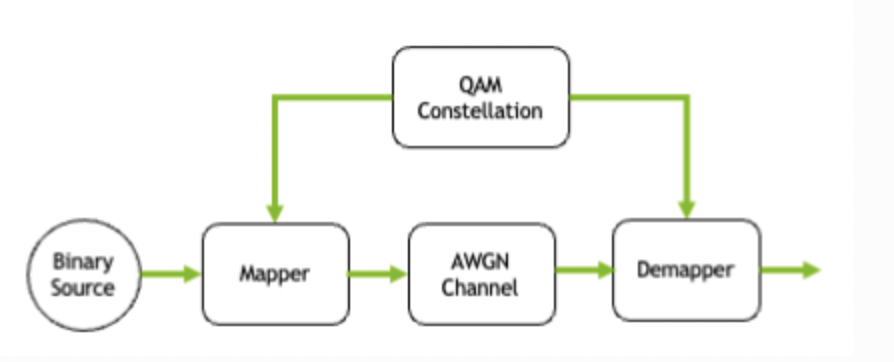

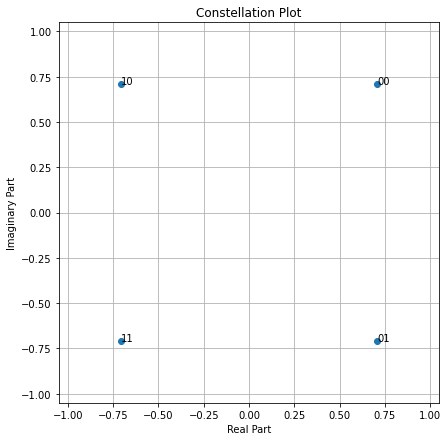

In [15]:
NUM_BITS_PER_SYMBOL = 2 # QPSK
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)

constellation.show();

In [16]:
mapper = sn.mapping.Mapper(constellation=constellation)

# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

In [18]:
binary_source = sn.utils.BinarySource()

In [19]:
awgn_channel = sn.channel.AWGN()

In [20]:
no = sn.utils.ebnodb2no(ebno_db=10.0,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

In [21]:
BATCH_SIZE = 64 # How many examples are processed by Sionna in parallel

bits = binary_source([BATCH_SIZE,
                      1024]) # Blocklength
print("Shape of bits: ", bits.shape)

x = mapper(bits)
print("Shape of x: ", x.shape)

y = awgn_channel([x, no])
print("Shape of y: ", y.shape)

llr = demapper([y, no])
print("Shape of llr: ", llr.shape)

Shape of bits:  (64, 1024)
Shape of x:  (64, 512)
Shape of y:  (64, 512)
Shape of llr:  (64, 1024)


In [22]:
num_samples = 8 # how many samples shall be printed
num_symbols = int(num_samples/NUM_BITS_PER_SYMBOL)

print(f"First {num_samples} transmitted bits: {bits[0,:num_samples]}")
print(f"First {num_symbols} transmitted symbols: {np.round(x[0,:num_symbols], 2)}")
print(f"First {num_symbols} received symbols: {np.round(y[0,:num_symbols], 2)}")
print(f"First {num_samples} demapped llrs: {np.round(llr[0,:num_samples], 2)}")

First 8 transmitted bits: [0. 0. 0. 1. 1. 1. 0. 1.]
First 4 transmitted symbols: [ 0.71+0.71j  0.71-0.71j -0.71-0.71j  0.71-0.71j]
First 4 received symbols: [ 0.69+0.67j  0.8 -0.53j -0.49-0.72j  0.57-0.84j]
First 8 demapped llrs: [-39.25 -37.84 -45.48  30.19  27.9   41.   -32.17  47.49]


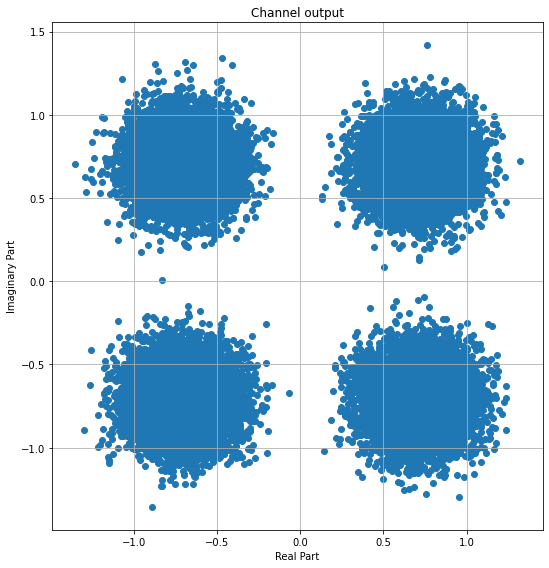

In [23]:
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Channel output')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.scatter(tf.math.real(y), tf.math.imag(y))
plt.tight_layout()

TBD: play with the SNR to visualize the impact on the received samples.

Now, let us package in Keras.

In [24]:
class UncodedSystemAWGN(Model): # Inherits from Keras Model
    def __init__(self, num_bits_per_symbol, block_length):
        """
        A keras model of an uncoded transmission over the AWGN channel.

        Parameters
        ----------
        num_bits_per_symbol: int
            The number of bits per constellation symbol, e.g., 4 for QAM16.

        block_length: int
            The number of bits per transmitted message block (will be the codeword length later).

        Input
        -----
        batch_size: int
            The batch_size of the Monte-Carlo simulation.

        ebno_db: float
            The `Eb/No` value (=rate-adjusted SNR) in dB.

        Output
        ------
        (bits, llr):
            Tuple:

        bits: tf.float32
            A tensor of shape `[batch_size, block_length] of 0s and 1s
            containing the transmitted information bits.

        llr: tf.float32
            A tensor of shape `[batch_size, block_length] containing the
            received log-likelihood-ratio (LLR) values.
        """

        super().__init__() # Must call the Keras model initializer

        self.num_bits_per_symbol = num_bits_per_symbol
        self.block_length = block_length
        self.constellation = sn.mapping.Constellation("qam", self.num_bits_per_symbol)
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

    # @tf.function # Enable graph execution to speed things up
    def __call__(self, batch_size, ebno_db):

        # no channel coding used; we set coderate=1.0
        no = sn.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=self.num_bits_per_symbol,
                                coderate=1.0)

        bits = self.binary_source([batch_size, self.block_length]) # Blocklength set to 1024 bits
        x = self.mapper(bits)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        return bits, llr

In [25]:
model_uncoded_awgn = UncodedSystemAWGN(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, block_length=1024)

*The next piece of code will take time without GPU.    please be patient.*   
How is block error defined in Sionna?.   
A block error is defined to happen if for two tensors at least one position in the last dimension differs (i.e., at least one bit wrongly received per codeword). The bit error rate the total number of erroneous positions divided by the total number of transmitted bits.

compute and plot the bit error rate (BER).

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 1.5868e-01 | 1.0000e+00 |      324983 |     2048000 |         2000 |        2000 |         1.0 |reached target block errors
   -2.579 | 1.4662e-01 | 1.0000e+00 |      300283 |     2048000 |         2000 |        2000 |         1.0 |reached target block errors
   -2.158 | 1.3528e-01 | 1.0000e+00 |      277062 |     2048000 |         2000 |        2000 |         1.3 |reached target block errors
   -1.737 | 1.2328e-01 | 1.0000e+00 |      252478 |     2048000 |         2000 |        2000 |         1.2 |reached target block errors
   -1.316 | 1.1247e-01 | 1.0000e+00 |      230333 |     2048000 |         2000 |        2000 |         0.6 |reached target block errors
   -0.895 | 1.0114e-01 | 1.0000e+00 |      207130 |     2048000 |

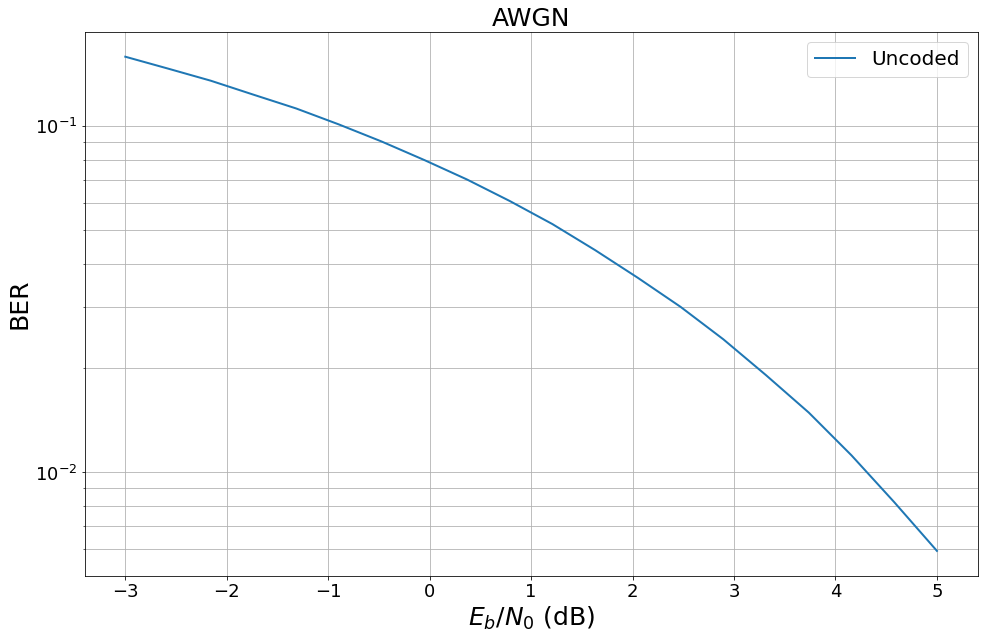

In [26]:
EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 5.0 # Maximum value of Eb/N0 [dB] for simulations
BATCH_SIZE = 2000 # How many examples are processed by Sionna in parallel

ber_plots = sn.utils.PlotBER("AWGN")
ber_plots.simulate(model_uncoded_awgn,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Uncoded",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=True);